In [161]:
import pandas as pd
import numpy as np
import collections

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split 

# инструмент для создания и обучения модели 
from sklearn.ensemble import RandomForestRegressor 

# инструменты для оценки точности модели 
from sklearn import metrics 

# модуль для работы с датами.
from datetime import datetime, timedelta
import time

# модуль для работы с регулярными выражениями
import re

# модуль для работы с полиноминальными признаками
from sklearn.preprocessing import PolynomialFeatures

# Модули для визуализации
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Модули для нахождения выбросов
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


# Функции

In [162]:
# Функция форматирует столбец cuisine_style
def form_cuisine(a):
    a = str(a)
    a = a.replace("'",'')
    a = a.replace('[', '')
    a = a.replace(']', '')
    a = a.split(', ')
    return a

# Функция для поиска самой встречающийся кухни.
def top_cuisine(a):
    cnt = collections.Counter()
    for i in a:
        for j in i:
            j = str(j)
            cnt[j] += 1
    return cnt.most_common(1)

# Функция для подсчета количества рпзличных кухонь.
def quant_cuisine(a):
    cnt = collections.Counter()
    for i in a:
        for j in i:
            j = str(j)
            cnt[j] += 1
    return cnt 

# Функции для отделения даты от коментариев
def form_reviews(a):
    a = str(a)
    a = a.strip('[]').split('[')
    del a[0]
    return a

# Функция для создания столбца разницы в днях коментвриев
def time_review(a):
    if len(a) == 2:
        a = a[0] - a[1]
    else: a = np.nan
    return abs(a)


# Функция для замены пустых списков в reviews_date на NaN
def NaN_for_rev(a):
    if a == []:
        a = np.nan
    return a

# Функция для замены знаков дол. числовыми значениями
def price_range_form(a):
    if a == '$$ - $$$':
        a = 999
    elif a == '$$$$':
        a = 9999
    elif a == '$':
        a = 9
    return a

# Функция для подсчета количества разнообразных кухонь
def len_cuisine(a):
    a = len(a)
    return a

# Функция для подсчета количества символов в коментариях.

def form_reviews(a):
    a = str(a)
    a = a.split('], [')
    a[0] = a[0].replace("'",'')
    a[0] = a[0].replace('[', '')
    a[0] = a[0].replace(']', '')
    a[0] = a[0].replace(',','')
    a[0] = a[0].replace(' ','')
    del a[1]
    a = a[0]
    
    return len(a)

# Функция для создания DUMMY признаков из столбца cuisine_style
def create_dummies(df, col, lst):
    for elem in lst:
        df[elem] = df[col].apply(lambda x: 1 if elem in x else 0)
    return df

# Функции для определения выбросов
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]


def outliers_z_score(ys, threshold=3):
    mean_y = np.mean(ys)
    std_y = np.std(ys)
    z_scores = [(y - mean_y) / std_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]


# Фунция для разделения столбца со временем
def time_column(a):
    if a == 0:
        a = a
    elif len(a) == 2:
        a = a[1]
    return a


# Функция для построения графиков распределения
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()



In [163]:
# Импортируем датасет и сразу меняем названия для удобства.

df = pd.read_csv('main_task_new.csv')
df.rename(columns={'Restaurant_id':'restaurant_id', 'City':'city', 'Cuisine Style':'cuisine_style', 
                   'Ranking':'ranking', 'Rating':'rating', 'Rating':'rating', 'Price Range':'price_range', 
                   'Number of Reviews':'number_of_reviews', 'Reviews':'reviews', 
                   'URL_TA':'url_ta', 'ID_TA':'id_ta'}, inplace=True)

In [164]:
df.columns

Index(['restaurant_id', 'city', 'cuisine_style', 'ranking', 'rating',
       'price_range', 'number_of_reviews', 'reviews', 'url_ta', 'id_ta'],
      dtype='object')

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      40000 non-null  object 
 1   city               40000 non-null  object 
 2   cuisine_style      30717 non-null  object 
 3   ranking            40000 non-null  float64
 4   rating             40000 non-null  float64
 5   price_range        26114 non-null  object 
 6   number_of_reviews  37457 non-null  float64
 7   reviews            40000 non-null  object 
 8   url_ta             40000 non-null  object 
 9   id_ta              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [166]:
# Создаем столбец с датами
pattern=re.compile('\d+[/]\d+[/]\d+')
df["reviews_date"] = df.reviews.apply(lambda x:re.findall(pattern,x))
df["reviews_date"] = df["reviews_date"].apply(lambda y:[pd.to_datetime(item)for item in y])

In [167]:
# Создадим признак разници времени написания коментариев
# и приведем данные к числовомк типу.
df['reviews_dif_date'] = df.reviews_date.apply(time_review)
df['reviews_dif_date'] = df['reviews_dif_date'].dt.days
df['reviews_date'] = df.reviews_date.apply(NaN_for_rev)

In [168]:
# Добавим признак самой популярной кухни в городе
top_cuisine = {'Paris': "['French']", 
          'Stockholm' : "['European', 'Swedish']", 
          'London': "['Bar', 'British', 'Pub']", 
          'Berlin': "['Italian']", 
          'Munich': "['Italian']" , 
          'Oporto' : "['European', 'Portuguese']", 
          'Milan': "['Italian']", 
          'Bratislava': "['Pub']", 
          'Vienna': "['Austrian', 'European']", 
          'Rome': "['Italian']",    
          'Barcelona': "['Spanish']", 
          'Madrid': "['Spanish']", 
          'Dublin': "['Irish', 'Bar', 'Pub']", 
          'Brussels': "['Belgian', 'European']", 
          'Zurich': "['Swiss', 'European']",  
          'Warsaw': "['Polish', 'European']",  
          'Budapest': "['European', 'Hungarian']", 
          'Copenhagen': "['European', 'Danish']", 
          'Amsterdam': "['Dutch', 'European']", 
          'Lyon': "['French']",   
          'Hamburg': "['Italian']", 
          'Lisbon': "['European', 'Portuguese']", 
          'Prague': "['European', 'Czech']", 
          'Oslo': "['Pub']", 
          'Helsinki': "['Bar', 'Pub']", 
          'Edinburgh': "['Cafe']",
          'Ljubljana': "['European', 'Slovenian']", 
          'Athens': "['Greek']", 
          'Luxembourg': "['French']", 
          'Krakow': "['Polish', 'European']", 
          'Geneva': "['French', 'Mediterranean', 'European']" }
df['top_cuisine'] = df['city'].map(top_cuisine)

In [169]:
# Создадим признак населения городов
population = {'Paris': 2196936, 'Stockholm' : 925934, 'London': 8416999, 'Berlin': 3469849 , 'Munich': 1488202 , 
              'Oporto' : 214349, 'Milan': 1378689, 'Bratislava': 437725, 'Vienna': 1897491, 'Rome': 2870500, 
              'Barcelona': 1664182, 'Madrid': 3266126, 'Dublin': 1173179, 'Brussels': 185103, 'Zurich': 42873,
              'Warsaw': 179065,  'Budapest': 1752286, 'Copenhagen': 615993, 'Amsterdam': 872757, 'Lyon': 506615,
              'Hamburg': 1841179, 'Lisbon': 505526, 'Prague': 1335084, 'Oslo': 673469, 'Helsinki': 656611, 'Edinburgh': 488100,
              'Ljubljana': 284355, 'Athens': 664046, 'Luxembourg': 114303, 'Krakow': 779115, 'Geneva': 200548 }


df['population'] = df['city'].map(population)

In [170]:
# Создадим признак площади городов
square = {'Paris': 105.4, 'Stockholm' : 188, 'London': 1572, 'Berlin': 891.68 , 'Munich': 310.71 , 
              'Oporto' : 41.66, 'Milan': 181.67, 'Bratislava': 368, 'Vienna': 414.75, 'Rome': 1287.36, 
              'Barcelona': 101.3, 'Madrid': 607, 'Dublin': 318, 'Brussels': 32.61, 'Zurich': 91.88,
              'Warsaw': 517.2,  'Budapest': 525.14, 'Copenhagen': 86.40, 'Amsterdam': 219.4, 'Lyon': 47.87,
              'Hamburg': 755.09, 'Lisbon': 100.05, 'Prague': 496, 'Oslo': 454, 'Helsinki': 213.8, 'Edinburgh': 118,
              'Ljubljana': 163.8, 'Athens': 412, 'Luxembourg': 51.46, 'Krakow': 327, 'Geneva': 15.93 }


df['square'] = df['city'].map(square)

In [171]:
# Выделим значения NAN в отдельный признак
df['cuisine_style_is_NAN'] = pd.isna(df['cuisine_style']).astype('uint8')

# Заполним пропуски в столбце cuisine_style на самую часто встречающуюся Vegetarian Friendly 
df.cuisine_style.fillna('Vegetarian Friendly', inplace = True)

In [172]:
# Используем функцию form_cuisine для форматирования столбца cuisine_style
df['cuisine_style'] = df.cuisine_style.apply(form_cuisine)

In [173]:
# Создадим признак сетевого ресторана где 1 = сетевой 0 = не сетевой.
rest_chain_temp = df.restaurant_id.value_counts()
rest_chain_temp = rest_chain_temp[rest_chain_temp >2]

rest_chain = []

for i in df.restaurant_id:
    if i in rest_chain_temp:
        rest_chain.append(1)
    elif i not in rest_chain_temp:
        rest_chain.append(0)

rest_chain = pd.Series(rest_chain)

df['rest_chain'] = rest_chain

In [174]:
# Заменяем знаки дол. числовыми значениями.
df['price_range'] = df['price_range'].apply(price_range_form)

In [175]:
# Создадим признак с количеством разнообразных кухонь
df['quantity_cuisine'] = df['cuisine_style'].apply(len_cuisine)

In [176]:
# Создадим признак с количеством символов в коментариях.
df['quantity_words'] = df.reviews.apply(form_reviews)

In [177]:
# Создадим признак количество ресторвнов в городе
df['rest_in_city']=df.groupby(["city"])['restaurant_id'].transform('count')

In [178]:
# Разделим reviews_date на 2 признака.
df['reviews_date'] = df['reviews_date'].fillna(0)
df['reviews_date_1'] = df['reviews_date'].apply(time_column)
df['reviews_date_2'] = df['reviews_date'].apply(time_column)

In [179]:
# Ячейка для выделения NaN признаков
# Отделяем пропуски в отдельный признак
df['number_of_reviews_is_NAN'] = pd.isna(df['number_of_reviews']).astype('uint8')
df['price_range_is_NAN'] = pd.isna(df['price_range']).astype('uint8')

In [180]:
# приводим к числовому виду столбец id_ta
df['id_ta'] = df['id_ta'].apply(lambda x: int(x[1::]))

# Заполняем пропуски

In [181]:
# Найдем самый часто встречающийся ценовой диапазон по городам и выясним, что это везде 999.
# Заполним пропуски этим значением 
a = df.groupby('city')['price_range'].value_counts().reset_index(name='counts')
city_top_price = a.iloc[0:93:3]
df.price_range = df.price_range.fillna(999)

df['number_of_reviews'].fillna(0, inplace = True)
df['reviews_dif_date'].fillna(0, inplace = True)



# Визуализация

<AxesSubplot:xlabel='city', ylabel='number_of_reviews'>

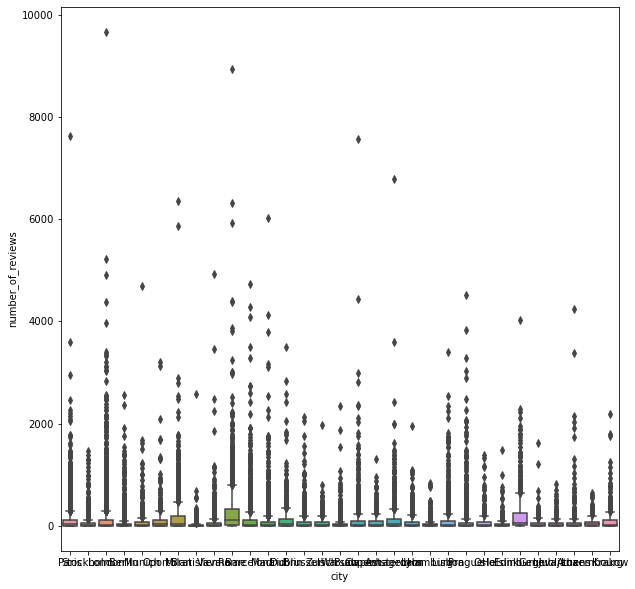

In [182]:
# Графики распределения для городов для обнаружения выбросов  - использовался различных признаков
sns.boxplot(x='city', y='number_of_reviews', data=df)

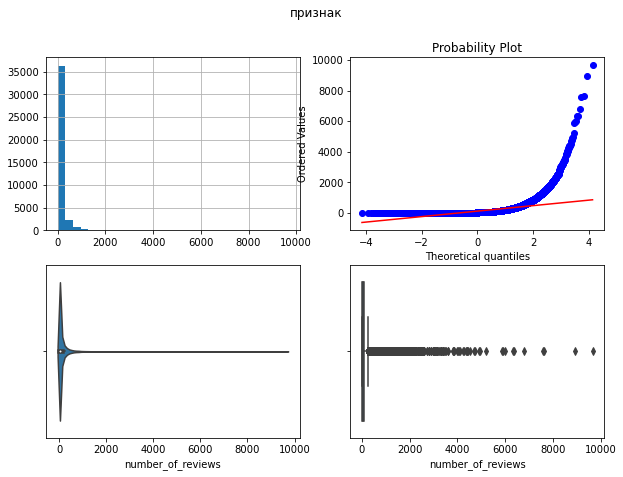

In [183]:
# Графики распределения - использовался для различных признаков
diagnostic_plots(df, 'number_of_reviews', 'признак')

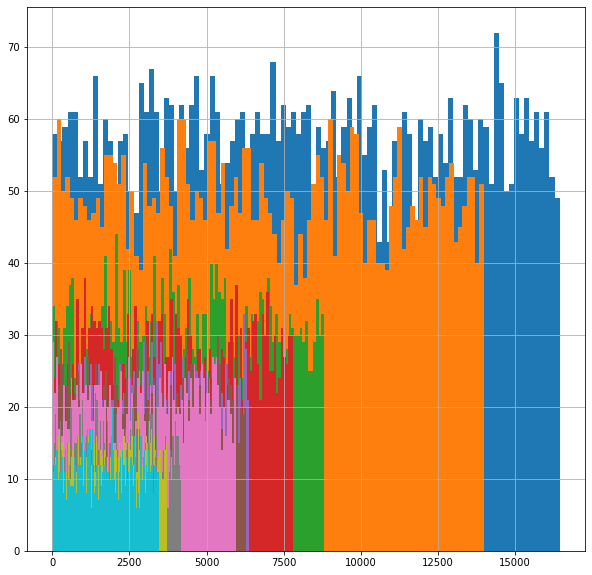

In [184]:
# Распределение признака ranking по городам
for x in (df['city'].value_counts())[0:10].index:
    df["ranking"][df['city'] == x].hist(bins=100)
plt.show()

<AxesSubplot:>

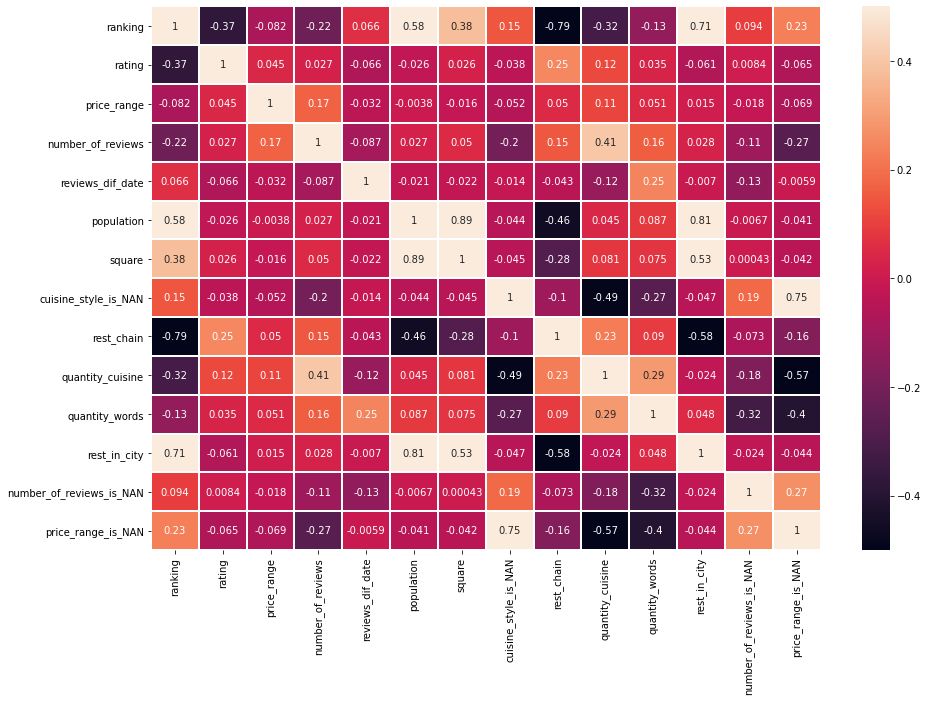

In [185]:
# Таблица кореляций
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.drop(['restaurant_id', 'cuisine_style',
                      'reviews', 'url_ta', 
                      'id_ta','city',
                      'top_cuisine',
                      'reviews_date'], axis=1).corr(),linecolor = "white",
                                       annot = True,linewidths = 1,vmax = 0.5, vmin = -0.5)

# Полиноминальные признаки созданые вручную

In [186]:
# Будем эксперементировать попробуем умножать делить 
# выбраные признаки и посмотрим как это будет сказываться на МАЕ
df['rest_in_city/population'] = df['rest_in_city'] / df['population']
df['rest_in_city/population'] = df['rest_in_city'] / df['population'] 
df['ranking*number_of_reviews'] = df['ranking']*df['number_of_reviews']
df['ranking*quantity_cuisine'] = df['ranking']*df['quantity_cuisine']
df['ranking/population'] = df['ranking'] / df['population'] 
df['ranking/rest_in_city'] = df['ranking']/df['rest_in_city']
df['number_of_reviews/ranking'] = df['number_of_reviews']/df['ranking']
df['ranking/quantity_cuisine'] = df['ranking']/df['quantity_cuisine']


# Возьмем средние значения признаков по городам
df['ranking_city_mean'] = df['city'].map(df.groupby('city')['ranking'].mean())
df['reviews_city_mean'] = df['city'].map(df.groupby('city')['number_of_reviews'].mean())
df['quantity_cuisine_mean'] = df['city'].map(df.groupby('city')['quantity_cuisine'].mean())
df['ranking_city_mean'] = df['city'].map(df.groupby('city')['ranking'].mean())
df['ranking_city_median'] = df['city'].map(df.groupby('city')['ranking'].median())
df['reviews_city_median'] = df['city'].map(df.groupby('city')['number_of_reviews'].median())


# Логарифмируем признак ranking
df['ranking'] = np.log(df['ranking'])

# Пробуем нормализовать распределение ранкинга по городам.
df["ranking_norm"] = df.groupby("city").ranking.apply(lambda x: (x - x.min())/(x.max() - x.min()))


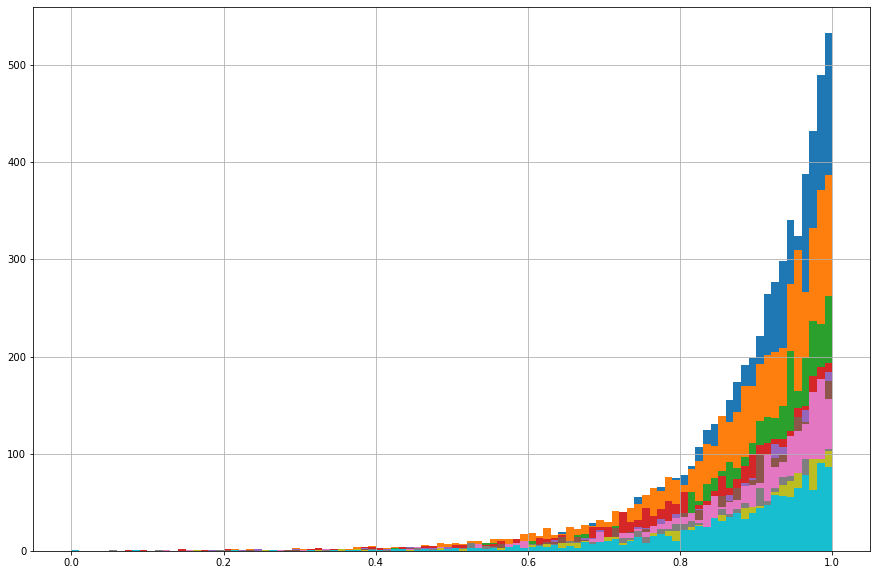

In [188]:
# Распределение признака ranking по городам после логарифмирования.


for x in (df['city'].value_counts())[0:10].index:
    df["ranking_norm"][df['city'] == x].hist(bins=100)
plt.show()

# Обработка выбросов

In [189]:
# Признак number_of_reviews исходя из графиков содержит большое количество 
# выбросов и распределен асисмитрично поэтому был использован 
# метод межквартильного размаха c заменой на предельные значения который не дал результатов (даже немного ухудшил).

# Видимо RandomForest устойчив к выбросам.



#K2 = 1.5
#IQR = df['number_of_reviews'].quantile(0.75) - df['number_of_reviews'].quantile(0.25)
#lower_boundary = df['number_of_reviews'].quantile(0.25) - (K2 * IQR)
#upper_boundary = df['number_of_reviews'].quantile(0.75) + (K2 * IQR)

#df['number_of_reviews'] = np.where(df['number_of_reviews'] > upper_boundary, upper_boundary, 
#                            np.where(df['number_of_reviews'] < lower_boundary, lower_boundary, df['number_of_reviews']))

#df['reviews_dif_date'] = np.where(df['reviews_dif_date'] > upper_boundary, upper_boundary, 
#                        np.where(df['reviews_dif_date'] < lower_boundary, lower_boundary, df['reviews_dif_date']))

# Dummy признаки

In [190]:
# Создадим Dummy признаки для city и cuisine_style.
X_dummy = df.copy()
cuisine_list = list(pd.Series(quant_cuisine(X_dummy.cuisine_style)).index)
X_dummy_price_range = pd.get_dummies(X_dummy.price_range, prefix = "DMY", prefix_sep = '-')

X_dummy_city = pd.get_dummies(X_dummy.city, prefix = "DMY", prefix_sep = '-')
X_dummy_cuisine = create_dummies(X_dummy, 'cuisine_style', cuisine_list)
X_dummy_top_cuisine = pd.get_dummies(X_dummy.top_cuisine, prefix = "DMY", prefix_sep = '-')

X = pd.concat([X_dummy_cuisine, X_dummy_city, X_dummy_top_cuisine,X_dummy_price_range], axis=1)

# Полиномиальные признаки

In [191]:
# Попробуем добавить еще полиномиальных признаков. После множественных тестов были оставлены только улудшающие модель. 
pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(X[['number_of_reviews','quantity_cuisine',
                                    'rest_in_city','square','rest_in_city',
                                    'ranking','quantity_cuisine_mean',
                                    'id_ta','reviews_dif_date','rest_in_city'
                                   ]])


poly_df = pd.DataFrame(poly_features)
X = pd.concat([X, poly_df], axis=1)
X.columns


Index([    'restaurant_id',              'city',     'cuisine_style',
                 'ranking',            'rating',       'price_range',
       'number_of_reviews',           'reviews',            'url_ta',
                   'id_ta',
       ...
                        56,                  57,                  58,
                        59,                  60,                  61,
                        62,                  63,                  64,
                        65],
      dtype='object', length=283)

In [192]:
# Удаляем столбцы с номинативными признаками и признаками которые ухудшают модель.
X = X.drop([ 'city', 'cuisine_style',
       'price_range', 'reviews', 'url_ta',
       'reviews_date', 'top_cuisine','reviews_date_1','reviews_date_2',
       'quantity_words',
       ], axis = 1)

# Нормализация не принесла результата.

In [193]:
# Также было опробована нормализация.
# Масштабирование MinMax.
# Не принесло результата.
# Не эфективно для RandomForest.


#scaler = MinMaxScaler() 
#scaled_values = scaler.fit_transform(X) 
#X.loc[:,:] = scaled_values

# Запуск обучения модели

In [194]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
y = X['rating']
X = X.drop(['restaurant_id', 'rating'], axis = 1)


In [195]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [196]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, random_state=42)  

# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [197]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19704549999999998


<AxesSubplot:>

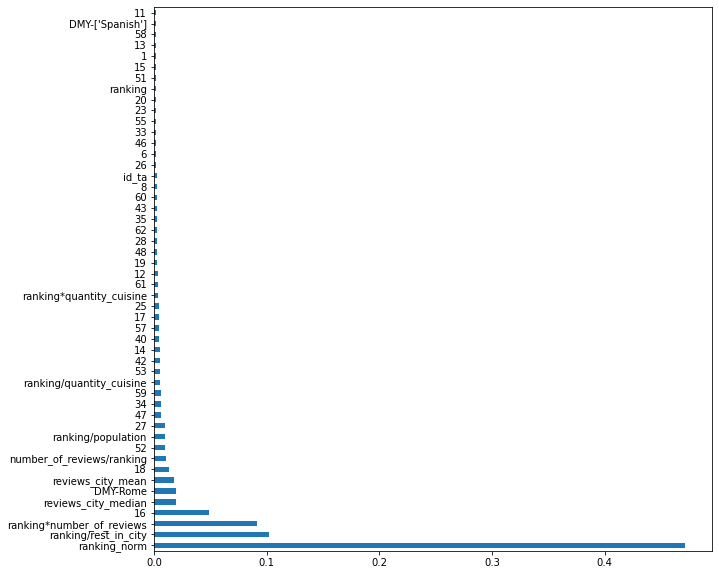

In [198]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')

# Выводы

Описание проекта
Цели.
1. Подготовить датасет к использованию моделью машинного обучения.
2. Найти скрытые взаимосвязи и выделить признаци наиболее коррелирующие с целевым признаком.
3. Очистить датасет от ненужной информации.
4. Оценить количество пропусков в столбцах и заполнить.
5. Познакомиться с платформой Kaggle

Данные представляют собой информацию об ресторанах и их рейтинг на сайте tripadvisor.

Этапы работы.
1. Вначале познакомился с данными оценил размерность, количество числовых и категориальных признаков.
2. Оценил количество пропусков. Выделил пропуски в отдельный признак. Разделил признак reviews на столбцы с датой и коментариями.Привел столбец с датами к типу datetime
3. Оценил распределение номинативных признаков с помошью графиков.
4. Оценил распределение числовых признаков с помошью таблицы корреляций и графиков.
5. Создал ряд признаков на основе имеющихся ручным способом.
6. Создал ряд полиномиальных признаков.
7. Из категориальных признаков создал Dummy признаки.
8. Попробовал работать с выбросами и изменять их предельными.
9. Попробовал нормировать признаки способом MinMax.
10. Результат залил на Kaggle

Выводы

1. Удалось немного улудшить показатели модели.
2. Некоторые признаки имеют большое количество выбросов, но обработка выбросов не принесла результатов.
3. Алгоритм RandomForestRegressor устойчив к выбросам.
4. Также было опробована нормализация. Масштабирование MinMax.
5. Тоже принесло результата. Не эфективно для RandomForestRegressor.
6. Однако хороший результат принесто маштабирование MinMax сгрупированого признака ranking_norm. для такого случая это ефективно. 
7. Были созданы признаки ручным способом а также полиномиальные признаки это принесло результат.для RandomForestRegressor эфективен такой подход.
8. Dummy признаки созданые из категориальных признаков оказались очень эфективны.
9. Дополнение датасета информацией из внешних источников (население, площадь городов) тоже принесло результат.

На что не хватило времени

1. К сожалению не хватило времени спарсить недостающие данные такие как  cuisine_style и price_range. Пришлось заменить на чаще всего встречающиеся значения.
2. Также не успел обернуть код в класс.

Саморефлексия
1. Поработать придеться еще надо всем.
2. Хорошо что познакомился с платформой Kaggle где можно постоянно практиковаться и прокачивать навыки.